Test File Download 





In [0]:
from google_drive_downloader import GoogleDriveDownloader as gdd
gdd.download_file_from_google_drive(file_id='122wV_YYCGzje3XxUWzWCHnlDWO6_gTRW', dest_path='./CropTest.zip', unzip=True)

Unzipping...Done.


#OCR Pre-process: Page Cropper

start..
orientation:  6


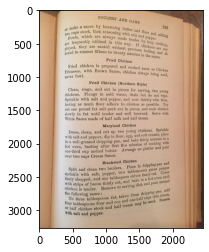

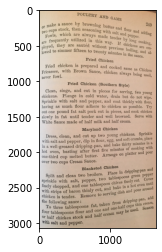

Saved /content/4.png -> /content//Res_4.png
start..
orientation:  6


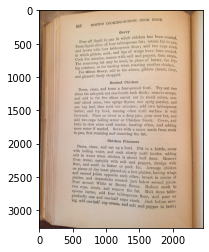

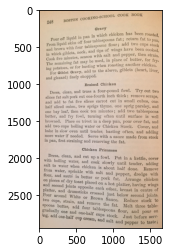

Saved /content/3.png -> /content//Res_3.png
start..
orientation:  6


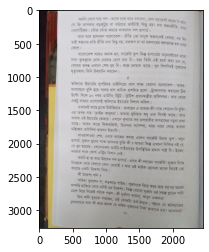

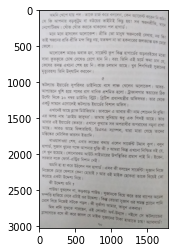

Saved /content/2.png -> /content//Res_2.png
start..
orientation:  6


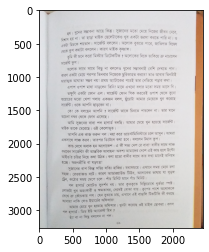

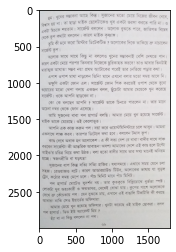

Saved /content/1.png -> /content//Res_1.png


In [0]:
import glob
import os
import random
import sys
import random
import math
import json
import logging
import cv2
from collections import defaultdict
from matplotlib import pyplot as plt
from PIL import Image, ImageDraw, ExifTags, ImageEnhance
import numpy as np
from scipy.ndimage.filters import rank_filter


def dilate(ary, N, iterations):  # def 5
    """Dilate using an NxN '+' sign shape. ary is np.uint8."""
    kernel = np.zeros((N,N), dtype=np.uint8)
    kernel[int((N-1)/2),:] = 1
    dilated_image = cv2.dilate(ary / 255, kernel, iterations=iterations)

    kernel = np.zeros((N,N), dtype=np.uint8)
    kernel[:,int((N-1)/2)] = 1
    dilated_image = cv2.dilate(dilated_image, kernel, iterations=iterations)
    dilated_image = dilated_image.astype(np.uint8)
    return dilated_image

def props_for_contours(contours, ary): # def 7
    """Calculate bounding box & the number of set pixels for each contour."""
    c_info = []
    for c in contours:
        x,y,w,h = cv2.boundingRect(c)
        c_im = np.zeros(ary.shape)
        cv2.drawContours(c_im, [c], 0, 255, -1)
        c_info.append({
            'x1': x,
            'y1': y,
            'x2': x + w - 1,
            'y2': y + h - 1,
            'sum': np.sum(ary * (c_im > 0))/255
        })
    return c_info


def union_crops(crop1, crop2): # def 9
    """Union two (x1, y1, x2, y2) rects."""
    x11, y11, x21, y21 = crop1
    x12, y12, x22, y22 = crop2
    return min(x11, x12), min(y11, y12), max(x21, x22), max(y21, y22)


def intersect_crops(crop1, crop2): # def 11
    x11, y11, x21, y21 = crop1
    x12, y12, x22, y22 = crop2
    return max(x11, x12), max(y11, y12), min(x21, x22), min(y21, y22)


def crop_area(crop): # def 8
    x1, y1, x2, y2 = crop
    return max(0, x2 - x1) * max(0, y2 - y1)


def find_border_components(contours, ary): #def 2
    borders = []
    area = ary.shape[0] * ary.shape[1]
    for i, c in enumerate(contours):
        x,y,w,h = cv2.boundingRect(c)
        if w * h > 0.5 * area:
          borders.append((i, x, y, x + w - 1, y + h - 1))
    return borders


def angle_from_right(deg): # def 12 (def 4)
    return min(deg % 90, 90 - (deg % 90))


def remove_border(contour, ary): # def 3
    """Remove everything outside a border contour."""
    # Use a rotated rectangle (should be a good approximation of a border).
    # If it's far from a right angle, it's probably two sides of a border and
    # we should use the bounding box instead.
    c_im = np.zeros(ary.shape)
    r = cv2.minAreaRect(contour)
    degs = r[2]
    if angle_from_right(degs) <= 10.0:
        box = cv2.boxPoints(r)
        box = np.int0(box)
        cv2.drawContours(c_im, [box], 0, 255, -1)
        cv2.drawContours(c_im, [box], 0, 0, 4)
    else:
        x1, y1, x2, y2 = cv2.boundingRect(contour)
        cv2.rectangle(c_im, (x1, y1), (x2, y2), 255, -1)
        cv2.rectangle(c_im, (x1, y1), (x2, y2), 0, 4)

    return np.minimum(c_im, ary)


def find_components(edges, max_components=16): # def 4
    """Dilate the image until there are just a few connected components.
    Returns contours for these components."""
    # Perform increasingly aggressive dilation until there are just a few
    # connected components.
    count = 21
    dilation = 5
    n = 1
    while count > 16:
        n += 1
        dilated_image = dilate(edges, N=3, iterations=n)
        contours, hierarchy = cv2.findContours(dilated_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        count = len(contours)
    Image.fromarray(edges).show()
    Image.fromarray(255 * dilated_image).show()
    return contours


def find_optimal_components_subset(contours, edges): # def 6
    """Find a crop which strikes a good balance of coverage/compactness.
    Returns an (x1, y1, x2, y2) tuple.
    """
    c_info = props_for_contours(contours, edges)
    c_info.sort(key=lambda x: -x['sum'])
    total = np.sum(edges) / 255
    area = edges.shape[0] * edges.shape[1]

    c = c_info[0]
    del c_info[0]
    this_crop = c['x1'], c['y1'], c['x2'], c['y2']
    crop = this_crop
    covered_sum = c['sum']

    while covered_sum < total:
        changed = False
        recall = 1.0 * covered_sum / total
        prec = 1 - 1.0 * crop_area(crop) / area
        f1 = 2 * (prec * recall / (prec + recall))
        #print '----'
        for i, c in enumerate(c_info):
            this_crop = c['x1'], c['y1'], c['x2'], c['y2']
            new_crop = union_crops(crop, this_crop)
            new_sum = covered_sum + c['sum']
            new_recall = 1.0 * new_sum / total
            new_prec = 1 - 1.0 * crop_area(new_crop) / area
            new_f1 = 2 * new_prec * new_recall / (new_prec + new_recall)

            # Add this crop if it improves f1 score,
            # _or_ it adds 25% of the remaining pixels for <15% crop expansion.
            # ^^^ very ad-hoc! make this smoother
            remaining_frac = c['sum'] / (total - covered_sum)
            new_area_frac = 1.0 * crop_area(new_crop) / crop_area(crop) - 1
            if new_f1 > f1 or (
                    remaining_frac > 0.25 and new_area_frac < 0.15):
                """
                print ('%d %s -> %s / %s (%s), %s -> %s / %s (%s), %s -> %s' % (
                        i, covered_sum, new_sum, total, remaining_frac,
                        crop_area(crop), crop_area(new_crop), area, new_area_frac,
                        f1, new_f1))
                """
                crop = new_crop
                covered_sum = new_sum
                del c_info[i]
                changed = True
                break

        if not changed:
            break

    return crop


def pad_crop(crop, contours, edges, border_contour, pad_px=15): #def 10
    """Slightly expand the crop to get full contours.
    This will expand to include any contours it currently intersects, but will
    not expand past a border.
    """
    bx1, by1, bx2, by2 = 0, 0, edges.shape[0], edges.shape[1]
    if border_contour is not None and len(border_contour) > 0:
        c = props_for_contours([border_contour], edges)[0]
        bx1, by1, bx2, by2 = c['x1'] + 5, c['y1'] + 5, c['x2'] - 5, c['y2'] - 5

    def crop_in_border(crop):
        x1, y1, x2, y2 = crop
        x1 = max(x1 - pad_px, bx1)
        y1 = max(y1 - pad_px, by1)
        x2 = min(x2 + pad_px, bx2)
        y2 = min(y2 + pad_px, by2)
        return crop
    
    crop = crop_in_border(crop)

    c_info = props_for_contours(contours, edges)
    changed = False
    for c in c_info:
        this_crop = c['x1'], c['y1'], c['x2'], c['y2']
        this_area = crop_area(this_crop)
        int_area = crop_area(intersect_crops(crop, this_crop)) 
        new_crop = crop_in_border(union_crops(crop, this_crop))
        if 0 < int_area < this_area and crop != new_crop:
            #print ('%s -> %s' % (str(crop), str(new_crop)))
            changed = True
            crop = new_crop

    if changed:
        return pad_crop(crop, contours, edges, border_contour, pad_px)
    else:
        return crop


def downscale_image(im, max_dim=1536): # def 1
    """Shrink im until its longest dimension is <= max_dim.
    Returns new_image, scale (where scale <= 1).
    """
    a, b = im.size
    if max(a, b) <= max_dim:
        return 1.0, im

    scale = 1.0 * max_dim / max(a, b)
    new_im = im.resize((int(a * scale), int(b * scale)), Image.ANTIALIAS)
    return scale, new_im

def rotation_fixing(image):
  if hasattr(image, '_getexif'): # only present in JPEGs
        for orientation in ExifTags.TAGS.keys(): 
            if ExifTags.TAGS[orientation]=='Orientation':
                break 
        e = image._getexif()       # returns None if no EXIF data
        if e is not None:
            exif=dict(e.items())
            orientation = exif[orientation] 
            print("orientation: ",orientation)
            if orientation == 3:   image = image.transpose(Image.ROTATE_180)
            elif orientation == 6: image = image.transpose(Image.ROTATE_270)
            elif orientation == 8: image = image.transpose(Image.ROTATE_90)
  return image

def Page_Crop(path, out_path):
    orig_im = Image.open(path)
    orig_im = rotation_fixing(orig_im)
    plt.imshow(orig_im)
    plt.show()
    scale, im = downscale_image(orig_im)
    edges = cv2.Canny(np.asarray(im), 100, 200)
    # TODO: dilate image _before_ finding a border. This is crazy sensitive!
    contours, hierarchy = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    borders = find_border_components(contours, edges)
    Y=borders
    borders =sorted(borders,key=lambda Y: (Y[3]-Y[1]) * (Y[4]-Y[2]))  # #{i, x1, y1, x2, y2} (x2 - x1) * (y2 - y1))  (i, x1, y1, x2, y2) : (x2 - x1) * (y2 - y1)

    border_contour = None
    if len(borders):
        border_contour = contours[borders[0][0]]
        edges = remove_border(border_contour, edges)

    edges = 255 * (edges > 0).astype(np.uint8)
    # Remove ~1px borders using a rank filter.
    maxed_rows = rank_filter(edges, -4, size=(1, 20))
    maxed_cols = rank_filter(edges, -4, size=(20, 1))
    debordered = np.minimum(np.minimum(edges, maxed_rows), maxed_cols)
    edges = debordered

    contours = find_components(edges)
    if len(contours) == 0:
        print ('%s -> (no text!)' % path)
        return

    crop = find_optimal_components_subset(contours, edges)
    crop = pad_crop(crop, contours, edges, border_contour)
    crop = [int(x / scale) for x in crop]  # upscale to the original image size.

    text_im = orig_im.crop(crop)
    #text_im.save(out_path)
    plt.imshow(text_im)
    plt.show()
    print ('Saved %s -> %s' % (path, out_path))


def main():
  File_dir = "/content/"
  for image_file in glob.iglob('*.png'):
    print("start..")
    src = File_dir+image_file
    out = File_dir+"/Res_"+image_file
    Page_Crop(src,out)

if __name__ == '__main__':
  main()
